# Neural Network
This script uses a neural network to model the relationship between brains and cognition.

In [4]:
import glob
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get Data

In [5]:
def get_subject_from_path(path):
    normalized_path = os.path.normpath(path)
    path_components = normalized_path.split(os.sep)
    return path_components[-2][4:]

In [6]:
# Search for all functional connectivity files and read them
fc_path = '/imaging3/owenlab/bpho/python_power_fc'
fc_paths = glob.glob(fc_path + '/**/power_fc.npy', recursive=True)

fcs = {}
for path in fc_paths:
    subject_id = get_subject_from_path(path)
    # print(subject_id)
    subject_fc = np.load(path)
    fcs[subject_id] = subject_fc[np.triu_indices(264, k=1)]
print("Number of functional connectivity:", len(fcs))
print("Number of features (connections):", fcs["NDARAP912JK3"].shape[0])

Number of functional connectivity: 722
Number of features (connections): 34716


## Get Labels

In [7]:
wisc_label_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects_with_WISC.csv"
wisc_labels = pd.read_csv(wisc_label_path, index_col='assessment WISC,EID')
# display(wisc_labels)

In [19]:
subject_ids = wisc_labels.index
# measure_text = "WISC_FW_Scaled"
# measure_col = f'assessment WISC,{measure_text}'
measure_text = "Age"
measure_col = 'assessment Basic_Demos,Age'

fc_matrices = []
measures = []

for subject_id in subject_ids:
    if subject_id not in fcs:
        continue
    
    fc_matrices.append(fcs[subject_id])
    measures.append(wisc_labels.at[subject_id, measure_col])
    
print("Num subjects with measures:", len(measures))

Num subjects with measures: 577


In [20]:
X = np.array(fc_matrices)
y = np.array(measures)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (577, 34716) y shape: (577,)


## Dense Neural Network

In [27]:
input_layer = layers.Input((34716,))
layer_1 = layers.Dense(5000, activation='relu')(input_layer)
layer_2 = layers.Dense(5000, activation='relu')(layer_1)
layer_3 = layers.Dense(1000, activation='relu')(layer_2)
output_layer = layers.Dense(1, activation=None)(layer_3)
model = keras.models.Model(input_layer, output_layer)
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 34716)]           0         
_________________________________________________________________
dense_24 (Dense)             (None, 5000)              173585000 
_________________________________________________________________
dense_25 (Dense)             (None, 5000)              25005000  
_________________________________________________________________
dense_26 (Dense)             (None, 1000)              5001000   
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 1001      
Total params: 203,592,001
Trainable params: 203,592,001
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, batch_size=32, epochs=10, 
          validation_split=0.2, shuffle=True)

Epoch 1/10
15/15 [==============================] - 13s 878ms/step - loss: 33085.7070 - accuracy: 0.0000e+00 - val_loss: 18.9126 - val_accuracy: 0.0000e+00
Epoch 2/10
15/15 [==============================] - 12s 802ms/step - loss: 17.8775 - accuracy: 0.0000e+00 - val_loss: 9.5831 - val_accuracy: 0.0000e+00
Epoch 3/10
15/15 [==============================] - 12s 796ms/step - loss: 19.0055 - accuracy: 0.0000e+00 - val_loss: 18.6999 - val_accuracy: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 12s 794ms/step - loss: 128.9484 - accuracy: 0.0000e+00 - val_loss: 10.5662 - val_accuracy: 0.0000e+00
Epoch 5/10
15/15 [==============================] - 12s 796ms/step - loss: 5.0997 - accuracy: 0.0000e+00 - val_loss: 8.1498 - val_accuracy: 0.0000e+00
Epoch 6/10
15/15 [==============================] - 12s 798ms/step - loss: 15.7198 - accuracy: 0.0000e+00 - val_loss: 11.7792 - val_accuracy: 0.0000e+00
Epoch 7/10
15/15 [==============================] - 12s 804ms/step - loss: 8.0736

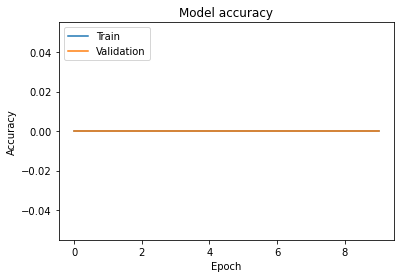

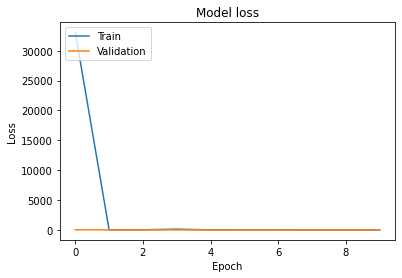

In [29]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Convolutional Neural Network